# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run114', 'ORACLE.run18', 'ORACLE.run150', 'ORACLE.run138', 'ORACLE.run120', 'ORACLE.run144', 'ORACLE.run126', 'ORACLE.run132'}


{'Wisig_4', 'Wisig_3', 'Wisig_1', 'Wisig_2'}


tensor([[[ 1.0476, -0.3400, -0.4962,  ..., -0.5054, -0.6157, -1.9757],
         [ 0.2114,  0.6249,  0.6616,  ..., -0.0184, -0.3124, -0.2114]],

        [[-0.1689,  0.2252, -0.2439,  ...,  0.1314, -0.3378, -0.5160],
         [ 0.3659,  0.4597, -1.2478,  ...,  0.3753,  0.2252,  0.3190]],

        [[ 0.3222, -0.1289,  0.0092,  ..., -0.6352, -0.3866, -0.6352],
         [-0.8837,  0.0828,  0.4326,  ..., -0.5247, -0.7732,  0.7916]],

        ...,

        [[ 1.0640,  0.4671,  1.1808,  ..., -0.4282, -0.5061, -0.2984],
         [-0.3503,  0.8240,  0.5255,  ..., -0.7072,  1.6868,  1.6155]],

        [[-0.0947,  1.2061,  0.0316,  ..., -0.6314, -0.1768, -0.1263],
         [-0.1389, -0.4862, -1.2629,  ..., -1.1619, -0.1137,  0.1705]],

        [[-0.4886, -1.0609, -0.6687,  ...,  0.0579, -0.7973,  0.2958],
         [ 0.2186,  0.1414, -0.1543,  ...,  0.0129,  0.5658, -0.9258]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.9243, train_label_loss: 2.7714, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2881.7221, train_label_loss: 2.8263, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2930.3013, train_label_loss: 1.4770, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2956.0163, train_label_loss: 1.6674, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3147.4953, train_label_loss: 2.1528, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3462.3076, train_label_loss: 1.6837, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3671.1883, train_label_loss: 1.3259, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2972.2682, train_label_loss: 0.9580, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2968.6815, train_label_loss: 0.8976, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2995.1835, train_label_loss: 1.7770, 


epoch: 1, source_val_acc_label: 0.5419, target_val_acc_label: 0.6109, source_val_label_loss: 1.2343, target_val_label_loss: 7.3869, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.7987, train_label_loss: 0.7226, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2987.9519, train_label_loss: 0.8309, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2998.0719, train_label_loss: 0.9058, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2979.1057, train_label_loss: 0.6553, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3200.8238, train_label_loss: 0.7623, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3457.4063, train_label_loss: 1.0978, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3579.0253, train_label_loss: 1.1288, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2957.8213, train_label_loss: 1.3506, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2964.7143, train_label_loss: 1.4710, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2956.8029, train_label_loss: 1.0306, 


epoch: 2, source_val_acc_label: 0.5963, target_val_acc_label: 0.6466, source_val_label_loss: 1.0752, target_val_label_loss: 7.2463, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.7404, train_label_loss: 1.3422, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2904.8428, train_label_loss: 0.9264, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3003.9960, train_label_loss: 0.9292, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2999.1419, train_label_loss: 0.6096, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3321.6174, train_label_loss: 0.8257, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3504.4777, train_label_loss: 1.2264, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3493.7494, train_label_loss: 1.1415, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3013.8116, train_label_loss: 0.5543, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3006.8678, train_label_loss: 0.4217, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3030.6734, train_label_loss: 0.5514, 


epoch: 3, source_val_acc_label: 0.6073, target_val_acc_label: 0.6606, source_val_label_loss: 1.0432, target_val_label_loss: 8.2806, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.7769, train_label_loss: 0.7974, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2945.2463, train_label_loss: 0.6404, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2977.2331, train_label_loss: 1.1425, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2988.4585, train_label_loss: 1.1457, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3310.2719, train_label_loss: 0.4770, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3468.3404, train_label_loss: 0.4842, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3535.0268, train_label_loss: 1.1996, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3697.5449, train_label_loss: 0.9284, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3649.5022, train_label_loss: 0.9250, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3629.3441, train_label_loss: 0.7000, 


epoch: 4, source_val_acc_label: 0.6093, target_val_acc_label: 0.6523, source_val_label_loss: 1.0588, target_val_label_loss: 9.4982, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.7275, train_label_loss: 0.5047, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 5030.0120, train_label_loss: 0.4525, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 4749.7047, train_label_loss: 1.2469, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3950.4868, train_label_loss: 1.0755, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3836.5691, train_label_loss: 0.9181, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3972.9344, train_label_loss: 0.5066, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3984.1521, train_label_loss: 0.8365, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3916.9618, train_label_loss: 0.7275, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3946.6783, train_label_loss: 0.9088, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3979.2491, train_label_loss: 0.4737, 


epoch: 5, source_val_acc_label: 0.6095, target_val_acc_label: 0.6791, source_val_label_loss: 1.0973, target_val_label_loss: 10.4897, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.9315, train_label_loss: 0.8061, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2987.0672, train_label_loss: 1.1500, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2951.1443, train_label_loss: 0.9370, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2918.9578, train_label_loss: 0.3581, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2927.6217, train_label_loss: 0.5621, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2949.8472, train_label_loss: 0.3753, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2994.6412, train_label_loss: 0.5950, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2934.0035, train_label_loss: 0.3665, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2943.7214, train_label_loss: 0.4753, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2953.4683, train_label_loss: 0.3527, 


epoch: 6, source_val_acc_label: 0.6088, target_val_acc_label: 0.6785, source_val_label_loss: 1.1583, target_val_label_loss: 11.3863, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 3.1813, train_label_loss: 0.2824, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2913.2841, train_label_loss: 0.9781, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3012.1978, train_label_loss: 0.4567, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3002.2491, train_label_loss: 0.9571, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2992.8734, train_label_loss: 0.3518, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2988.0864, train_label_loss: 0.8343, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2985.3638, train_label_loss: 0.4890, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2954.9926, train_label_loss: 0.3805, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2985.0525, train_label_loss: 0.3670, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3070.8828, train_label_loss: 0.4536, 


epoch: 7, source_val_acc_label: 0.6041, target_val_acc_label: 0.6783, source_val_label_loss: 1.2196, target_val_label_loss: 12.5896, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 3.1353, train_label_loss: 0.7130, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2922.2371, train_label_loss: 0.6657, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3012.3182, train_label_loss: 0.8219, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3026.5673, train_label_loss: 0.3205, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3007.2824, train_label_loss: 0.3671, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3003.3775, train_label_loss: 0.4501, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3017.1139, train_label_loss: 0.5874, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2959.2784, train_label_loss: 0.6750, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2963.1138, train_label_loss: 0.3248, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3268.3668, train_label_loss: 0.3995, 


epoch: 8, source_val_acc_label: 0.6037, target_val_acc_label: 0.6823, source_val_label_loss: 1.3329, target_val_label_loss: 14.8137, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.0611, train_label_loss: 0.3865, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2923.1311, train_label_loss: 0.2392, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3253.2512, train_label_loss: 0.2539, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3390.9021, train_label_loss: 0.1226, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3332.4372, train_label_loss: 0.3850, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3334.1090, train_label_loss: 0.4997, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3382.3805, train_label_loss: 0.5616, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3515.0882, train_label_loss: 0.1209, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3664.1966, train_label_loss: 0.3213, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 4460.5672, train_label_loss: 0.3784, 


epoch: 9, source_val_acc_label: 0.6036, target_val_acc_label: 0.6860, source_val_label_loss: 1.4155, target_val_label_loss: 15.5124, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 3.1323, train_label_loss: 0.4811, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2988.2379, train_label_loss: 0.1415, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3023.5344, train_label_loss: 0.6720, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2956.0225, train_label_loss: 0.1304, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2923.2360, train_label_loss: 0.4914, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2974.7261, train_label_loss: 0.3611, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2961.0045, train_label_loss: 0.0981, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3081.4356, train_label_loss: 0.3827, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3400.4407, train_label_loss: 0.1171, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3471.4716, train_label_loss: 0.0384, 


epoch: 10, source_val_acc_label: 0.5962, target_val_acc_label: 0.6875, source_val_label_loss: 1.5495, target_val_label_loss: 16.9352, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.7913, train_label_loss: 0.5156, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2910.3022, train_label_loss: 0.2909, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2973.9964, train_label_loss: 0.5252, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2983.7249, train_label_loss: 0.0481, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3017.6092, train_label_loss: 0.0934, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3008.0304, train_label_loss: 0.1888, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3042.3558, train_label_loss: 0.2406, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3396.9866, train_label_loss: 0.2696, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3398.5397, train_label_loss: 0.1498, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3224.9511, train_label_loss: 0.1416, 


epoch: 11, source_val_acc_label: 0.5964, target_val_acc_label: 0.6918, source_val_label_loss: 1.5602, target_val_label_loss: 17.8658, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.8060, train_label_loss: 0.2628, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2906.9877, train_label_loss: 0.3577, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2951.4399, train_label_loss: 0.3557, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3003.4668, train_label_loss: 0.4133, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2978.4125, train_label_loss: 0.2297, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2979.6621, train_label_loss: 0.2103, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3268.2909, train_label_loss: 0.1644, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3384.1147, train_label_loss: 0.1137, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3371.0411, train_label_loss: 0.3479, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2924.5941, train_label_loss: 0.0431, 


epoch: 12, source_val_acc_label: 0.5974, target_val_acc_label: 0.6912, source_val_label_loss: 1.6586, target_val_label_loss: 18.9368, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.7589, train_label_loss: 0.2623, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3030.4687, train_label_loss: 0.1483, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2960.9040, train_label_loss: 0.3326, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2967.8326, train_label_loss: 0.2895, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2931.5619, train_label_loss: 0.0871, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3167.7908, train_label_loss: 0.1022, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3354.1176, train_label_loss: 0.0951, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3525.3910, train_label_loss: 0.1093, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3007.0043, train_label_loss: 0.2594, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2978.7085, train_label_loss: 0.1498, 


epoch: 13, source_val_acc_label: 0.5995, target_val_acc_label: 0.6866, source_val_label_loss: 1.7604, target_val_label_loss: 20.6329, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.1234, train_label_loss: 0.1047, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3340.0946, train_label_loss: 0.2696, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3513.3026, train_label_loss: 0.3349, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3521.8773, train_label_loss: 0.0918, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3865.9621, train_label_loss: 0.3140, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3784.5900, train_label_loss: 0.1694, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3497.3758, train_label_loss: 0.0755, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3089.3276, train_label_loss: 0.1257, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2993.0330, train_label_loss: 0.2706, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3000.0273, train_label_loss: 0.0501, 


epoch: 14, source_val_acc_label: 0.5980, target_val_acc_label: 0.6843, source_val_label_loss: 1.8045, target_val_label_loss: 21.3771, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.7538, train_label_loss: 0.1296, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2982.8102, train_label_loss: 0.1150, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2955.9217, train_label_loss: 0.0227, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3004.6708, train_label_loss: 0.0163, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3430.1000, train_label_loss: 0.0960, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3410.8370, train_label_loss: 0.2563, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3339.1777, train_label_loss: 0.4316, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2949.0387, train_label_loss: 0.1313, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3015.4317, train_label_loss: 0.0898, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3060.3772, train_label_loss: 0.0150, 


epoch: 15, source_val_acc_label: 0.5942, target_val_acc_label: 0.6853, source_val_label_loss: 1.8833, target_val_label_loss: 21.8764, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

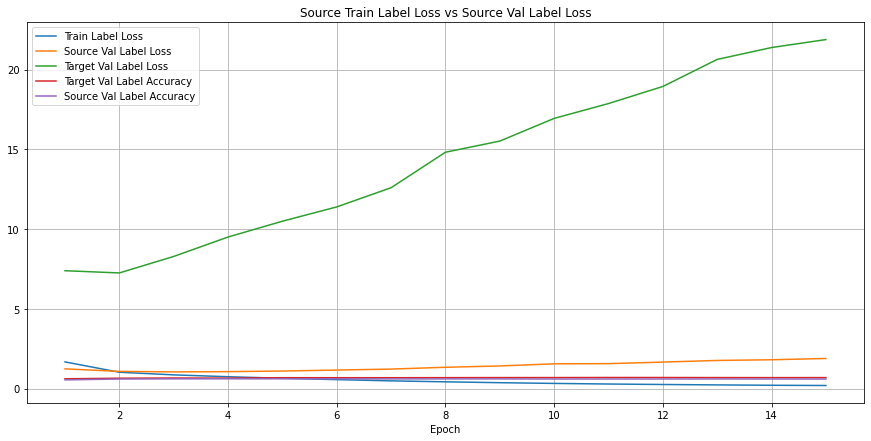

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

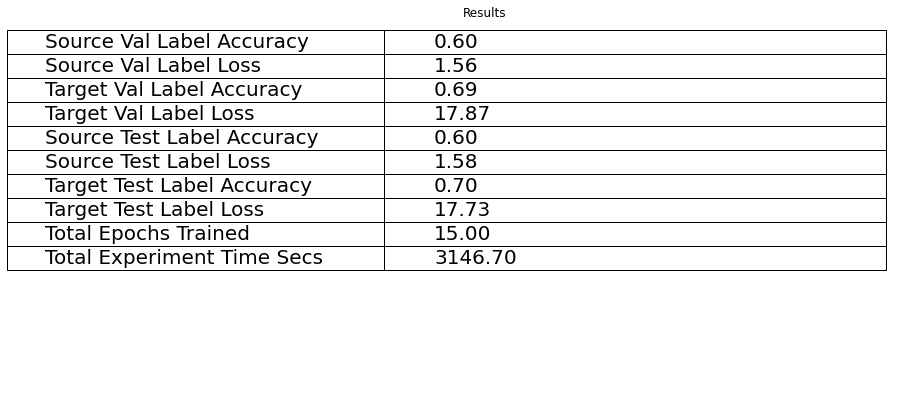

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

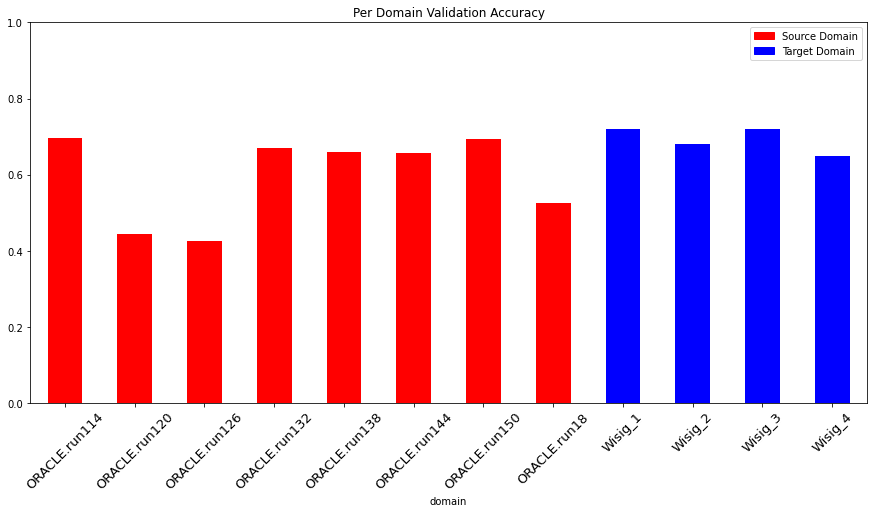

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.5995768229166667 Target Test Label Accuracy: 0.6954979360165119
Source Val Label Accuracy: 0.5963541666666666 Target Val Label Accuracy: 0.6918034957627118


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}